<a href="https://colab.research.google.com/github/bicudorafa/fraud-detection-case/blob/main/meli_fraud_prevention_case_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Prevention Case

Welcome to FREEDOM, a leader in the online commerce and payment systems market in your region, with over 25 years of history and a successful growth track record.

At FREEDOM, Fraud Prevention is the reference sector internally and externally on all security topics for transactions within its ecosystem. It ensures the security of users' operations through the application of tools, predictive-analytical models, and innovative technologies. It is one of the company's areas that allows taking risks and accelerating growth.
As a new member of the FREEDOM Fraud Prevention team, you have been allocated to your first data science project, congratulations!
For this project, the Analytics team has already extracted a sample of transactions that have been labeled as Fraud (fraud column with a value equal to 1) or Non-Fraud (fraud column with a value equal to 0). They also included the scores from an existing fraud predictive model in production (score column).

**Your main objectives in this project are:**
1. *Establish the baseline*: for this, it is necessary to evaluate the performance of the current machine learning model that is in production.
    - What is the predictive performance of the model? Which metrics are most appropriate for this analysis and why?
2. *Train new machine learning model(s) for fraud prediction*: those are going to be assessed as candidates to replace the current one.
   - You are free to generate new features if appropriate, and include any technique or analysis you believe suits the case.
    - Specify the techniques and algorithms used for both: data preprocessing stage, and and to train the new model(s)? Comment on your decisions.
    - Explicitly compare the new model(s) you trained with the current model in terms of predictive performance?
3. *Business metrics and decision making based on models*: define a cutoff point to reject transactions based on the output of the model
Consider that FREEDOM's commission rate is 5% on the value of a correctly approved payment (monto column), and for each approved fraudulent transaction we lose 100% of the payment value. The cutoff point should maximize FREEDOM's profit based on this definition.

# Setup

In [ ]:
# recent bug on XGB requires an older version of scikit-learn (https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags)
import sys

!{sys.executable} -m pip uninstall -y scikit-learn --quiet
!{sys.executable} -m pip install scikit-learn==1.5.2 missingno \
  deepchecks xgboost catboost optuna -U --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.3 MB/s eta 0:00:00


In [ ]:
# checking if version is indeed correct (if not, try to reset the runtime)
import sklearn
sklearn.__version__

'1.5.2'

In [ ]:
# Import libraries

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import data_integrity, train_test_validation, model_evaluation
from deepchecks.tabular.checks import WeakSegmentsPerformance
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import precision_score, recall_score

# model specific packages
import shap
import optuna
import optuna.visualization as vis
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, TunedThresholdClassifierCV
from sklearn.metrics import (
    make_scorer,
    log_loss,
    roc_auc_score,
    brier_score_loss,
    average_precision_score
)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning:

The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




In [ ]:
# Auxiliary User Defined Functions

def modified_z_score(series):
    "Common threshold: 3.5"
    median = series.median()
    mad = np.median(np.abs(series - median))
    if mad == 0:
        return np.zeros(len(series))
    return 0.6745 * (series - median) / mad


def calculate_class_importance(pd_series):
    "Utils function to calculate category percentual importance on a categorical column"
    count = pd_series.value_counts().reset_index(name='n')
    count['pct_share'] = (count.n / count.n.sum()) * 100
    count['cum_pct_share'] = count.pct_share.cumsum()
    return count

def business_metric(y_true, y_pred, amount):
    """Adapted version from the one suggested at Sklearn Documentation:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_cost_sensitive_learning.html#post-tuning-the-decision-threshold-for-cost-sensitive-learning"""
    mask_true_positive = (y_true == 1) & (y_pred == 1)
    mask_true_negative = (y_true == 0) & (y_pred == 0)
    mask_false_positive = (y_true == 0) & (y_pred == 1)
    mask_false_negative = (y_true == 1) & (y_pred == 0)
    fraudulent_refuse = 0# mask_true_positive.sum() * 50
    fraudulent_accept = -amount[mask_false_negative].sum()
    legitimate_refuse = 0# mask_false_positive.sum() * -5
    legitimate_accept = (amount[mask_true_negative] * 0.05).sum()
    return fraudulent_refuse + fraudulent_accept + legitimate_refuse + legitimate_accept

# defining custom scorer to account for profit on model evaluation
sklearn.set_config(enable_metadata_routing=True)
business_scorer = make_scorer(business_metric).set_score_request(amount=True)

In [ ]:
# Common constansts across the analysis

TARGET = 'is_fraud'
TS_COLUMN = 'ts'
RANDOM_SEED = 42
N_SPLITS = 5
TRAIN_SIZE = 0.8

In [ ]:
# Attention! Please use this cell to load the dataset that will be needed in this case.

raw_data = pd.read_csv('fraud_dataset_v2.csv', index_col="Unnamed: 0")

In [ ]:
raw_data.head().T

,0,1,2,3,4
a,4,4,4,4,2
b,0.7685,0.755,0.7455,0.7631,0.7315
c,94436.24,9258.5,242549.09,18923.9,5728.68
d,20.0,1.0,3.0,50.0,15.0
e,0.444828,0.0,0.0,0.482385,0.0
f,1.0,33.0,19.0,18.0,1.0
g,BR,BR,AR,BR,BR
h,5,0,23,23,2
i,Máquininha Corta Barba Cabelo Peito Perna Pelo...,Avental Descartavel Manga Longa - 50 Un. Tnt ...,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,Caneta Delineador Carimbo Olho Gatinho Longo 2...,Resident Evil Operation Raccoon City Ps3
j,cat_8d714cd,cat_64b574b,cat_e9110c5,cat_d06e653,cat_6c4cfdc


# Data Cleaning


- **No duplicates**
- **Missing data analysis** over time:
  - Feature o: A boolean feature where most values are null. During EDA, investigate whether it can be treated as a categorical feature.
  - Features b and c:
    - These are numerical features with a considerable number of null values.
    - The missing values follow a distinct time-dependent pattern, suggesting they result from the system generating the data.
    - In a real scenario, an investigation into the data source would be necessary.
    - **Assumption**: Since this investigation is not possible, I assume these null values will persist in production. Therefore, I'll process them to evaluate their impact as predictive features.
  - Features d, q, m:
    - These numerical features have missing values in 0.2% of the total dataset and 0.3% of fraud samples.
    - Most missing occurrences are concentrated in a specific time period.
    - To avoid biasing the model with rare values, I'll assume these missing values are due to poor logging and remove them.
    - The same approach will be applied to l, f, and g.
    - **Note**: If missing values were expected but rare in production, a different approach would be needed.
- Column Type Adjustments: Low-cardinality columns will be converted into categorical or boolean types.
- **Outlier Analysis**:
  - Feature monto:
    - This variable has a skewed distribution, which is expected due to the financial nature of the data.
    - Its maximum value aligns with what is expected for online commerce payments.
  - Features c, e, f, r:
    - Similar skewness as monto.
    - I attempted a manual inspection but, due to the lack of business context, it is difficult to determine whether these values are inconsistent.
    - Proposed action: Be mindful of their impact when using models that are sensitive to outliers (e.g., Logistic Regression).
- **Categorical Columns Analysis**:
  - Features product_category & product_name:
    - These are highly fragmented and will not be used directly in the first iteration of the analysis.
    - If time allows, consider using embedding techniques to extract meaningful representations from product_name.
  - Features a, n, o, p, s:
    - These numerical features have a low number of unique values.
    - I'll treat them as categorical features.
    - Feature a: Besides converting it to categorical, I will group smaller categories to enhance interpretability and reduce the risk of overfitting.
  - Feature g (Country column):
    - Apply a similar grouping approach as done for a.
- v0_model_score: Exclude it from the Exploratory Data Analysis (EDA). Reintroduce it for model evaluation.
- Numerical columns with negative minimum values:
  - It is unclear whether these values are valid (part of the expected distribution) or incorrect imputations.
  - Without knowledge of the Data Generation Process (DGP), assessing them is difficult.
  - Visual inspection did not reveal any clear anomalies.
- Other Anomalies
  - Index Duplication:
    - The index is duplicated in the range 0 → 99,999, affecting 40% of the data.
    - Open question: Why does this duplication occur? Could this be a separate validation or test set?
  - Product Name Similarity Check:
    - I inspected records with identical product_name values to detect potential similarities.
    - Finding: The values appear to be the same, but further validation is needed.

## General Checks

In [ ]:
raw_data.duplicated().sum()

0

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   a       250000 non-null  int64  
 1   b       228526 non-null  float64
 2   c       228526 non-null  float64
 3   d       249406 non-null  float64
 4   e       250000 non-null  float64
 5   f       249985 non-null  float64
 6   g       249676 non-null  object 
 7   h       250000 non-null  int64  
 8   i       250000 non-null  object 
 9   j       250000 non-null  object 
 10  k       250000 non-null  float64
 11  l       249985 non-null  float64
 12  m       249406 non-null  float64
 13  n       250000 non-null  int64  
 14  o       66372 non-null   object 
 15  p       250000 non-null  object 
 16  q       249406 non-null  float64
 17  r       250000 non-null  int64  
 18  s       250000 non-null  int64  
 19  fecha   250000 non-null  object 
 20  monto   250000 non-null  float64
 21  score   250000 n

Columns with skewed distributions to be investigated: c, e, f, r and monto

In [ ]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
a,250000.0,3.710736,0.908846,0.000000,3.00000,4.000000,4.000000,5.000000e+00
b,228526.0,0.727647,0.132455,0.000000,0.67780,0.755200,0.806100,1.000000e+00
c,228526.0,257801.060924,840623.502209,0.160000,9714.78500,43578.310000,144911.600000,1.387874e+07
d,249406.0,21.828208,20.088081,-1.000000,3.00000,15.000000,49.000000,5.100000e+01
e,250000.0,0.222844,2.650651,0.000000,0.00000,0.106154,0.283668,8.333333e+02
f,249985.0,51.288385,681.830910,-5.000000,1.00000,9.000000,33.000000,1.452740e+05
h,250000.0,14.259116,14.196752,-1.000000,3.00000,9.000000,21.000000,5.900000e+01
k,250000.0,0.497599,0.288246,0.000004,0.24691,0.495780,0.746415,9.999948e-01
l,249985.0,2325.054195,1711.840924,-1.000000,931.00000,1960.000000,3469.000000,7.544000e+03
m,249406.0,302.817615,321.876881,-1.000000,44.00000,197.000000,463.000000,2.225000e+03


## Missing Value Analysis
- Feature o: A boolean feature where most values are null. During EDA, investigate whether it can be treated as a categorical feature.
- Features b and c:
  - These are numerical features with a considerable number of null values.
  - The missing values follow a distinct time-dependent pattern, suggesting they result from the system generating the data.
  - In a real scenario, an investigation into the data source would be necessary.
  - **Assumption**: Since this investigation is not possible, I assume these null values will persist in production. Therefore, I'll process them to evaluate their impact as predictive features.

<Axes: >

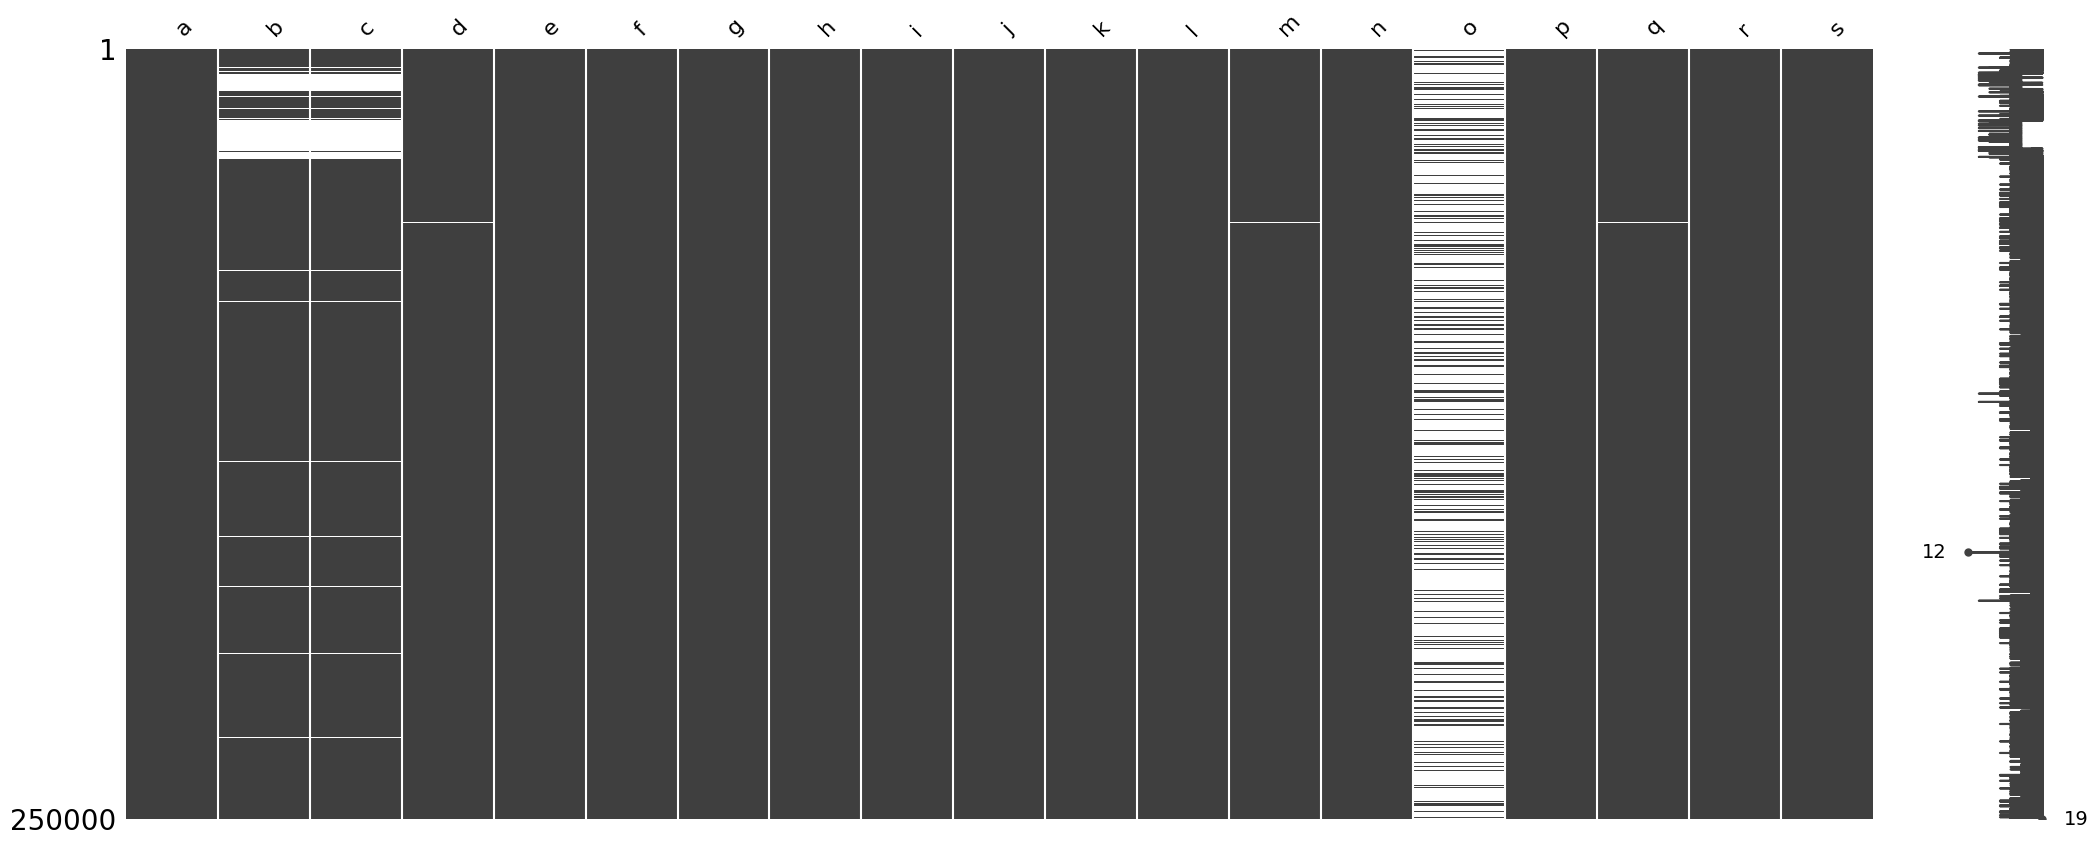

In [ ]:
msno.matrix(
    raw_data
    .assign(date=lambda x: pd.to_datetime(raw_data.fecha))
    .sort_values("date")
    .loc[:, 'a':'s']
)

  - Features d, q, m:
    - These numerical features have missing values in 0.2% of the total dataset and 0.3% of fraud samples.
    - Most missing occurrences are concentrated in a specific time period.
    - To avoid biasing the model with rare values, I'll assume these missing values are due to poor logging and remove them.
    - The same approach will be applied to l, f, and g.
    - **Note**: If missing values were expected but rare in production, a different approach would be needed.

<Axes: >

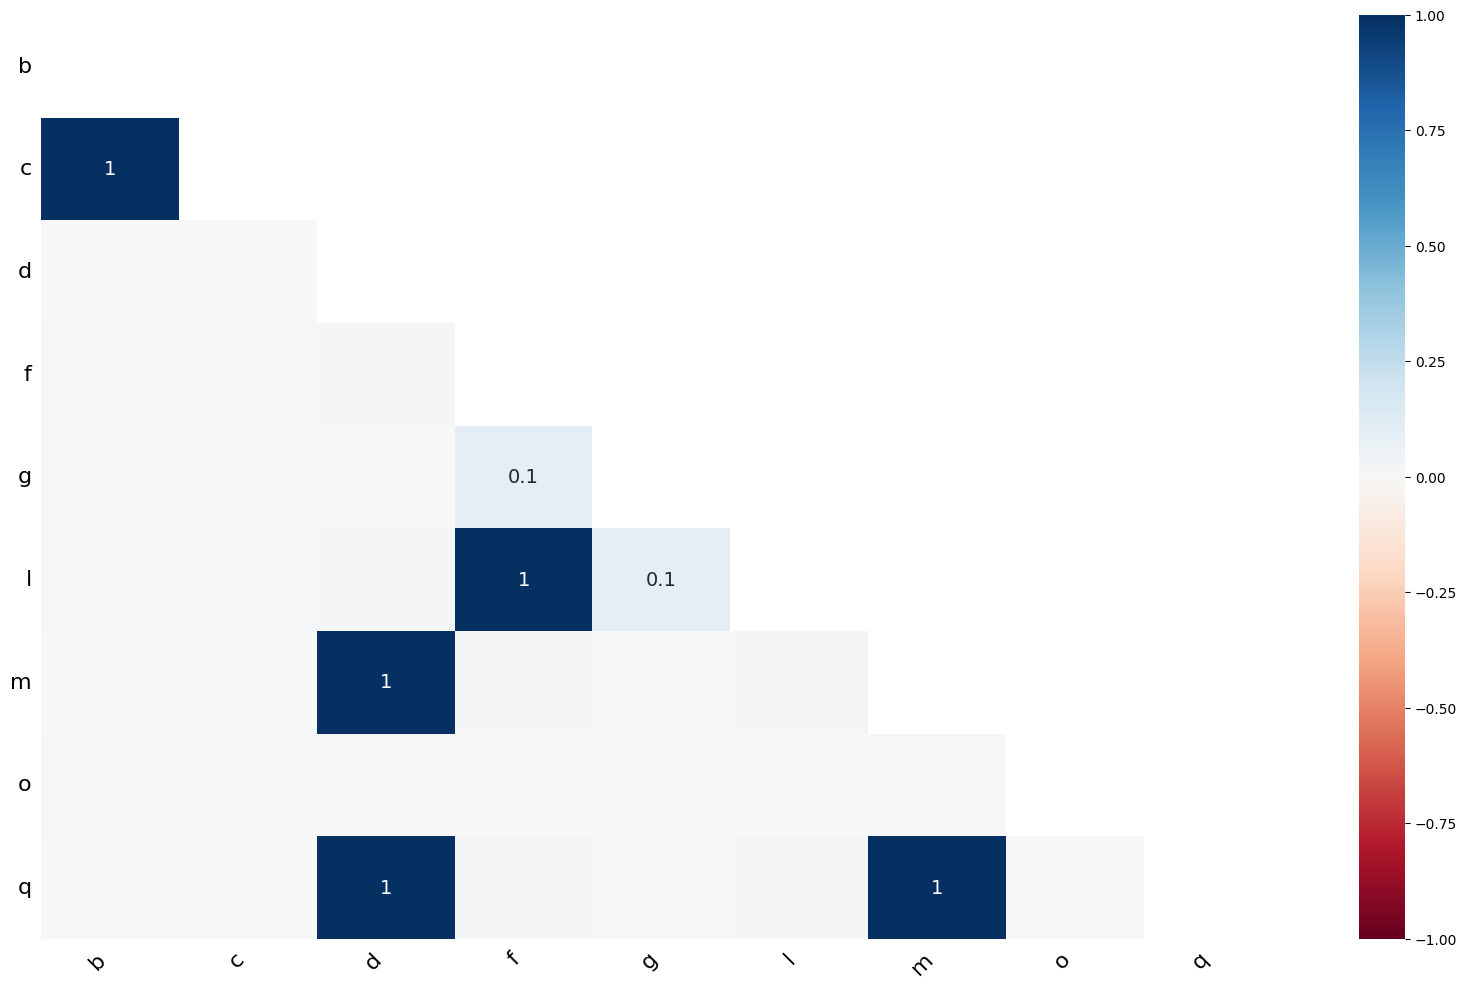

In [ ]:
msno.heatmap(raw_data.loc[:, 'a':'s'])

In [ ]:
raw_data.groupby(raw_data[['d', 'q', 'm']].isna().all(axis=1)).fraude.agg(['count', 'mean', 'sum'])

,count,mean,sum
False,249406,0.029963,7473
True,594,0.048822,29


In [ ]:
raw_data.groupby(raw_data[['l', 'f']].isna().all(axis=1)).fraude.agg(['count', 'mean', 'sum'])

,count,mean,sum
False,249985,0.03001,7502
True,15,0.00000,0


In [ ]:
raw_data.groupby(raw_data[['g']].isna().all(axis=1)).fraude.agg(['count', 'mean', 'sum'])

,count,mean,sum
False,249676,0.029987,7487
True,324,0.046296,15


In [ ]:
pd.to_datetime(
    raw_data[(raw_data[['d']].isna().all(axis=1))].fecha
).agg(['min', 'max'])

,fecha
min,2020-03-08 12:18:13
max,2020-04-21 21:53:50


## Outlier Analysis

Monto, as financial metrics, is skewed, but doesn't present abnormal values

In [ ]:
max(raw_data['monto'])

3696.35

Mannually inspecting some of the outliers, but, honestly, without business knowldge, is very difficult to spot any data inconsistency

In [ ]:
# ineffective to the extreme skewness
# raw_data[modified_z_score(raw_data['e']) > 5].T
raw_data[raw_data['c'] > raw_data['c'].quantile(0.999)].T

,555,3174,4788,4955,5734,5848,6028,8659,9013,9220,...,82162,84476,91501,92098,94918,96137,96209,97096,98390,99881
a,4,4,4,4,4,4,4,4,4,4,...,5,3,5,5,3,3,4,3,3,3
b,0.7553,0.7582,0.7586,0.7552,0.7587,0.7554,0.7581,0.7553,0.7562,0.7553,...,0.7533,0.7554,0.7558,0.7571,0.758,0.7564,0.7577,0.757,0.7581,0.7571
c,11651027.59,10836492.29,10885626.65,10307910.55,10814229.07,11775483.68,10779142.6,11729991.63,11502664.96,10329317.45,...,10133975.44,11628295.06,10398910.62,11338894.23,11015181.03,11199328.33,11083762.02,11408997.09,10776101.03,11333806.0
d,1.0,50.0,50.0,50.0,50.0,18.0,3.0,27.0,3.0,11.0,...,18.0,2.0,2.0,3.0,1.0,51.0,4.0,21.0,3.0,18.0
e,0.835298,0.248541,0.0,0.0,0.274364,0.0,0.701383,0.0,0.0,0.359937,...,0.0,0.0,0.265694,0.0,0.0,0.311446,0.0,0.0,0.500701,0.701383
f,11.0,11.0,27.0,4.0,0.0,26.0,6.0,9.0,2.0,61.0,...,1.0,7.0,2.0,13.0,6.0,15.0,2.0,22.0,0.0,-1.0
g,AR,AR,AR,AR,US,AR,AR,AR,AR,AR,...,AR,AR,AR,AR,US,AR,AR,GB,AR,AR
h,28,4,4,0,4,3,19,3,8,3,...,1,6,39,1,7,5,6,9,24,20
i,Organizador Soporte Y Perchero P Escobas Limpi...,Pava Eléctrica Yelmo Pe-3902 Negra 220v 1.7l,Celular Motorola Moto E6 Plus 32gb 2gb Garantí...,Auriculares Inalámbricos Skullcandy Crusher Wi...,Pava Eléctrica Yelmo Pe-3902 Negra 220v 1.7l,Motorola Moto E E6 Plus 32 Gb Bright Cherry 2 ...,Secador De Pelo Plegable Bixler Beb-07c Mango ...,Motorola Moto E E6 Plus Special Edition 64 Gb ...,Monitor Samsung 27 F350 Led Full Hd 60hz 180p Pce,Pava Eléctrica Bixler Peb-03a Blanca Y Roja 1.7l,...,Celular Motorola Moto G8 64gb 4gb Xt-2045 Gara...,Celular Motorola Moto E6 Play 4g 32gb 2gb Gtia...,Waflera Electrica Yelmo Wm-1901 Waffles En Min...,Celular Motorola Moto G8 Plus 4g 64gb 4gb Gara...,Celular Motorola One Action 128gb Triple Cámar...,Router Mercusys Mw305r Blanco,Celular Motorola Moto E6 Play 4g 32gb 2gb Gtia...,Monitor Samsung 27 F350 Led Full Hd 60hz 180p Pce,Alfombra Infantil Piso Manta Antigolpes Bebe G...,Secador De Pelo Plegable Bixler Beb-07c Mango ...
j,cat_1eca167,cat_925128f,cat_43b9c10,cat_ea962fb,cat_925128f,cat_43b9c10,cat_e2dd214,cat_43b9c10,cat_09e3852,cat_925128f,...,cat_43b9c10,cat_43b9c10,cat_9f94f1f,cat_43b9c10,cat_43b9c10,cat_bf6dfa0,cat_43b9c10,cat_09e3852,cat_a6619c2,cat_e2dd214


In [ ]:
raw_data[raw_data['e'] > raw_data['e'].quantile(0.999)].T

,2606,3429,3911,3926,4085,4704,5772,5956,6819,6879,...,91048,92379,95308,96087,96245,97070,97117,98418,98580,99821
a,4,4,4,4,3,4,4,3,3,4,...,4,4,3,3,4,5,4,3,2,3
b,0.5619,0.7388,0.7873,0.3915,0.8631,0.2787,0.6265,0.8102,0.8894,0.4026,...,0.6078,0.639,0.7549,1.0,NaN,0.2196,0.6741,0.6723,1.0,1.0
c,13321.79,133841.86,5952.61,2278.77,4006.82,195.08,35652.45,1312.94,411.62,676.7,...,16625.3,858073.32,24.44,150.46,NaN,2261.41,10358.33,538.45,69.44,3897.66
d,50.0,2.0,38.0,3.0,23.0,1.0,40.0,50.0,3.0,50.0,...,2.0,51.0,26.0,51.0,49.0,6.0,49.0,1.0,2.0,18.0
e,5.129419,5.918197,19.3996,4.937274,165.666667,19.090455,20.069372,25.0,6.5,20.17,...,6.571286,6.122245,15.590455,25.833333,7.295082,10.4998,30.0,20.4,65.91,17.5
f,0.0,1.0,50.0,4.0,9.0,7.0,0.0,253.0,16.0,33.0,...,6.0,21.0,33.0,71.0,2561.0,0.0,280.0,0.0,356.0,245.0
g,AR,BR,AR,AR,BR,AR,AR,BR,BR,AR,...,AR,AR,AR,BR,BR,AR,BR,BR,BR,BR
h,16,42,6,21,2,1,31,4,4,2,...,1,30,19,1,-1,0,1,3,6,0
i,Resorte Eje De Embrague Rouser Ns200,Mouse Pad Gamer Preto Pequeno Anti-derrapante ...,Toner Alternativo Sp377 Para Sp377 Dnwx 377sfnwx,Pintura Tela Acrilex 37 Ml,Rolo De Fita Twing,Medias Calton Envío,Soporte Fijo Tv Lcd Led 42 47 49 50 55 Cs4040 ...,Kit Engate Rapido Zarelho Mais Barra De Torcao...,Janela De Ferro Esquadria 60 X60,Extensor F2,...,Rollo De Cinta Impreso Peligro (un Lado) 80mm ...,Cable Adaptador Rca A Miniplug Hembra 40cm Tec...,Figuritas Mundial Rusia 2018 Panini - Lote Par...,Bateria Bi Motora,Camisa Estampa Cerveja Heineken Estilo Futebol...,Remeras Nba Nike Mochila Y Bolso,Componente Para Repocição,Suspensao Recondicionada,Petzl Huit Amtibrulure (frete Grátis),Armários Para Cozinha (10cm)² Anúncio Do Projeto
j,cat_5c9f37e,cat_ecc6934,cat_71b6c9c,cat_e6fcb5f,cat_9ad7db1,cat_fafc0f4,cat_4ff2cdf,cat_c0ccda0,cat_d9753d4,cat_ae953e7,...,cat_a8fabe9,cat_efed068,cat_34bcef1,cat_66fabf5,cat_f0ec611,cat_6ef8cc6,cat_d9753d4,cat_d9753d4,cat_9ba475f,cat_5124efe


## Categorical columns analysis

(Possibly) categorical variables identified: 'a', 'n', 'o', 'p', 's'

In [ ]:
raw_data.nunique()['a': 's'].to_frame().T

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s
0,6,7672,135090,53,43208,1559,51,61,127804,8324,150000,7389,1882,2,2,2,52,91391,2


"a" can be treated as categorical column, and with smaller values of it together (0 ->2)

In [ ]:
calculate_class_importance(raw_data.a)

,a,n,pct_share,cum_pct_share
0,4,158087,63.2348,63.2348
1,3,35121,14.0484,77.2832
2,5,28773,11.5092,88.7924
3,2,18988,7.5952,96.3876
4,1,8132,3.2528,99.6404
5,0,899,0.3596,100.0000


'g' clearly represent country, but it's very fragmented. I'll analyse which are the relevant countries to be used as categories

In [ ]:
calculate_class_importance(raw_data.g)[:4]

,g,orders,pct_share,cum_pct_share
0,BR,185579,74.327929,74.327929
1,AR,53634,21.481440,95.809369
2,UY,5044,2.020218,97.829587
3,US,3794,1.519569,99.349157


Product Category: too fragmented to create meaningful categorical columns

In [ ]:
prod_cat_count = calculate_class_importance(raw_data.j)
prod_cat_count[prod_cat_count.pct_share > 0.1]

,j,n,pct_share,cum_pct_share
0,cat_43b9c10,3697,1.4788,1.4788
1,cat_604df77,2987,1.1948,2.6736
2,cat_d69bed9,2978,1.1912,3.8648
3,cat_6c4cfdc,2418,0.9672,4.8320
4,cat_4249bd8,1984,0.7936,5.6256
...,...,...,...,...
156,cat_496ee26,253,0.1012,38.3260
157,cat_4d9c208,252,0.1008,38.4268
158,cat_fb9867e,252,0.1008,38.5276
159,cat_a11d605,252,0.1008,38.6284


## Other Anomalies

Inspecting numerical columns with min negative values to assess if they might be null values sign
- no sign of it as their transition from 0 or bigger values is smooth

In [ ]:
raw_data.describe()
neg = ['d', 'f', 'h', 'l', 'm']

for col in neg:
  display(
      raw_data[col]
      .value_counts()
      .sort_index()
      .loc[:8]
      .to_frame().T
  )

d,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
count,124,6236,32642,22650,13074,8935,6751,5567,4712,4161


f,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
count,4,23,134,603,6327,33520,22305,14790,11423,9400,7755,6865,6141,5497


h,-1,0,1,2,3,4,5,6,7,8
count,2689,18378,19956,14585,10994,10691,11313,10794,9945,8933


l,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
count,369,2413,751,278,176,172,156,136,145,112


m,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
count,3295,19555,5917,1992,1567,1381,1305,1295,1215,1006


For some reason, the data 100k of the data has duplicated index (possible sign of concat of 2 distinct datasets)

- why? Does it have any impact?

In [ ]:
raw_data.index.value_counts()[raw_data.index.value_counts() > 1].sort_index().to_frame().T

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
count,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


Inspecting equal items to see if there is any similarity -> **a is the same**

In [ ]:
raw_data[raw_data.i == 'Fone De Ouvido Sem Fio Xiaomi Airdots Preto'][:10].T

,323,1717,3302,5687,6453,8375,9690,9783,10663,16790
a,4,4,4,4,4,4,4,4,4,4
b,0.7838,0.8481,0.7921,NaN,0.7543,NaN,0.7429,0.8509,0.7868,0.7472
c,30016.11,8866.47,513004.99,NaN,683049.04,NaN,516436.05,5442.44,487816.01,205003.1
d,50.0,4.0,34.0,1.0,9.0,2.0,41.0,50.0,10.0,50.0
e,0.067521,0.0,0.0,0.087685,0.06,0.12231,0.06699,0.098296,0.165404,0.598947
f,14.0,0.0,5.0,0.0,2.0,22.0,33.0,51.0,1.0,15.0
g,BR,BR,BR,BR,BR,BR,BR,BR,BR,BR
h,1,0,2,0,2,1,1,1,1,0
i,Fone De Ouvido Sem Fio Xiaomi Airdots Preto,Fone De Ouvido Sem Fio Xiaomi Airdots Preto,Fone De Ouvido Sem Fio Xiaomi Airdots Preto,Fone De Ouvido Sem Fio Xiaomi Airdots Preto,Fone De Ouvido Sem Fio Xiaomi Airdots Preto,Fone De Ouvido Sem Fio Xiaomi Airdots Preto,Fone De Ouvido Sem Fio Xiaomi Airdots Preto,Fone De Ouvido Sem Fio Xiaomi Airdots Preto,Fone De Ouvido Sem Fio Xiaomi Airdots Preto,Fone De Ouvido Sem Fio Xiaomi Airdots Preto
j,cat_89ea11f,cat_89ea11f,cat_89ea11f,cat_89ea11f,cat_89ea11f,cat_89ea11f,cat_89ea11f,cat_89ea11f,cat_89ea11f,cat_89ea11f


Investigating if "j" is more likelly product category than other common identifier (e.g. user). Due to strong 1:1 relationship to product_name, I'll assume it's product category indeed.

In [ ]:
prod_cat = raw_data.groupby('i').j.nunique().sort_values().to_frame()
prod_cat.groupby(prod_cat.j.apply(lambda x: 1 if x > 1 else 0)).count()

,j
j,
0,127538
1,266


## Staging & Analysis Data creation
- Applied all transformation proposed above (numeric to categories, missing data rows dropping and so on)
- Also, I applied some renaming to facilitate Exploratory Data Analysis

In [ ]:
# based on the missing value analysis
cols_with_nulls_drop = ['d', 'q', 'm',
                        'l', 'f', 'g']
to_drop_sample = raw_data[cols_with_nulls_drop].isna().any(axis=1)

# staging data creation
staging_data = (
     raw_data
     .copy() # avoid changes to the original data
     .assign(
         fecha=lambda x: pd.to_datetime(x["fecha"]),
         # categorical columns as numerical
         a=lambda x: np.where(x["a"].between(0, 2), "0-2", x["a"].astype(str)),
         # concetrating country column
         g=lambda x: np.where(x["g"].isin(['BR', 'AR']), x["g"], "Other"),
         # standardize bool columns
         n=lambda x: x["n"].astype(str),
         o=lambda x: x["o"].fillna('NA'),
         s=lambda x: x["s"].astype(str),
     )
     .rename(
         columns={
             # basic renaming
             'fecha': 'ts', 'fraude': 'is_fraud', 'monto': 'amount',
             'score': 'v0_model_score',
             # analysis oriented
             'g': 'country', 'i': 'product_name', 'j': 'product_category',
             # dtype_oriented
             'a': 'cat_1', 'n': 'bool_1',
             'o': 'bool_2', 'p': 'bool_3', 's':'bool_4',
        }
     )
     .loc[~to_drop_sample, :]
     .reset_index(drop=True)
 )

# droping column that will be needed for model evaluation, but not for EDA
analysis_data = staging_data \
  .drop(columns=['product_category', 'product_name', 'v0_model_score'])

analysis_data.head().T

,0,1,2,3,4
cat_1,4,4,4,4,0-2
b,0.7685,0.755,0.7455,0.7631,0.7315
c,94436.24,9258.5,242549.09,18923.9,5728.68
d,20.0,1.0,3.0,50.0,15.0
e,0.444828,0.0,0.0,0.482385,0.0
f,1.0,33.0,19.0,18.0,1.0
country,BR,BR,AR,BR,BR
h,5,0,23,23,2
k,0.883598,0.376019,0.516368,0.154036,0.855798
l,240.0,4008.0,1779.0,1704.0,1025.0


# EDA

- **High Correlation Between Feature Pairs**:
Certain pairs of features exhibit extremely high correlation (>0.9), indicating redundancy. Upon further analysis, their relationships suggest that one feature can be derived from the other. The following decisions were made:
  - ('bool_3', 'bool_4'): These features are identical, so 'bool_4' will be dropped.
  - ('c', 'r'): Feature 'r' is equivalent to np.floor(c), but with fewer missing values. Therefore, 'c' will be dropped.
  - ('d', 'q'): 'd' follows a linear transformation of 'q' (d = B * q + N). Since 'q' provides the same information, 'd' will be removed.
- **Fraud Incidence During Late Night Hours**:
  - There is a higher observed fraud rate during late-night hours (dawn).
  - However, these hours also have lower transaction volume and variance, which may suggest that the pattern is due to randomness rather than a meaningful trend.
  - To mitigate overfitting to specific time periods, a categorical feature indicating "late-night transactions" will be created and tested in modeling.
- Low Discriminatory Power for Features 'b', 'h', and 'k':
  - Based on visual analysis, these features do not appear to contribute significantly to distinguishing fraudulent from non-fraudulent transactions.
  - Despite this, they will be retained in the first iteration of the modeling process for further evaluation.
- Fraud Rate Drop on April 15th:
  - This drop does not coincide with a reduction in transaction volume, suggesting that external factors influenced fraud patterns on this date.
  - While this could be an interesting avenue for investigation, it falls outside the scope of this analysis.
- **Category 'cat_1' (Previously Feature 'a') = 5**:
  - This category has no fraud cases despite representing 10% of the dataset.
  - In a real-world setting, this would require further investigation or additional data collection to determine whether fraud is truly absent or simply underreported.
  - For this analysis, it will be retained as it provides a super strong predictive signal.
- **Feature Importance Analysis**:
  - The default Predictive Power Score (PPS) test (from Deepchecks) did not yield meaningful insights.
  - To further assess univariate feature importance, Mutual Information (MI) was chosen due to its robustness in detecting non-linear associations and its suitability for large datasets.
  - However, MI also failed to provide strong insights, likely due to the extreme class imbalance in the dataset.


In [ ]:
integrity_df = Dataset(analysis_data, cat_features=['cat_1', 'country', 'bool_1',
                                                    'bool_2', 'bool_3', 'bool_4'],
                       datetime_name=TS_COLUMN, label=TARGET)

integ_suite = data_integrity()
suite_result = integ_suite.run(integrity_df)
suite_result.show()

<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Data Integrity Suite

## Time Series Analysis
- No apparent daily sazonality
- Fraud Rate Drop on April 15th:
This drop does not coincide with a reduction in transaction volume, suggesting that external factors influenced fraud patterns on this date.

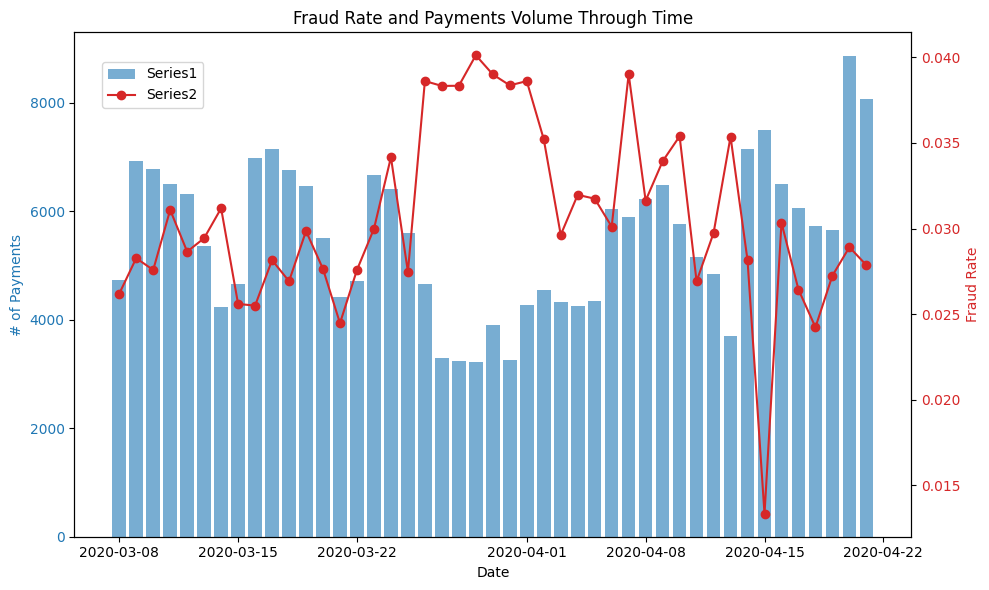

In [ ]:
daily_fraud = (
    analysis_data
    .groupby(analysis_data.ts.dt.floor('D'))
    .is_fraud
    .agg(['count', 'mean'])
)

# Initialize the figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar chart on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('# of Payments', color=color)
ax1.bar(daily_fraud.index, daily_fraud['count'],
        color=color, alpha=0.6, label='Series1')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Fraud Rate', color=color)
ax2.plot(daily_fraud.index, daily_fraud['mean'],
         color=color, marker='o', label='Series2')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and legends
plt.title('Fraud Rate and Payments Volume Through Time')
fig.tight_layout()  # Adjust layout to prevent overlap
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

# Display the plot
plt.show()

Hourly investigation:

There is a higher observed fraud rate during late-night hours (dawn).
However, these hours also have lower transaction volume and variance, which may suggest that the pattern is due to randomness rather than a meaningful trend.

To mitigate overfitting to specific time periods, a categorical feature indicating "late-night transactions" will be created and tested in modeling.

In [ ]:
hourly_avg = (
    analysis_data
    .groupby(analysis_data.ts.dt.floor('H'))
    .is_fraud
    .agg(['count', 'mean'])
    .reset_index()
)

<ipython-input-101-81fc59079ad8>:3: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



<ipython-input-102-814d00cfc400>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




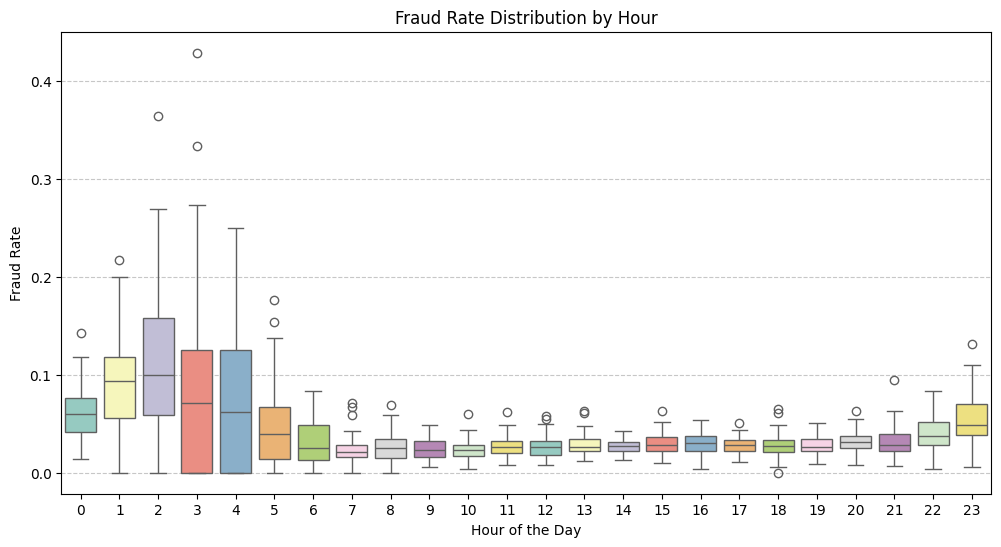

In [ ]:
# Assuming your DataFrame is named 'df' with a 'value' column and a datetime index
hourly_avg['hour'] = hourly_avg.ts.dt.hour  # Extract hour from datetime index

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='mean', data=hourly_avg, palette="Set3")

# Add labels and title
plt.title("Fraud Rate Distribution by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Fraud Rate")
plt.xticks(range(24))  # Ensure all hours are shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<ipython-input-103-eef5697003a0>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




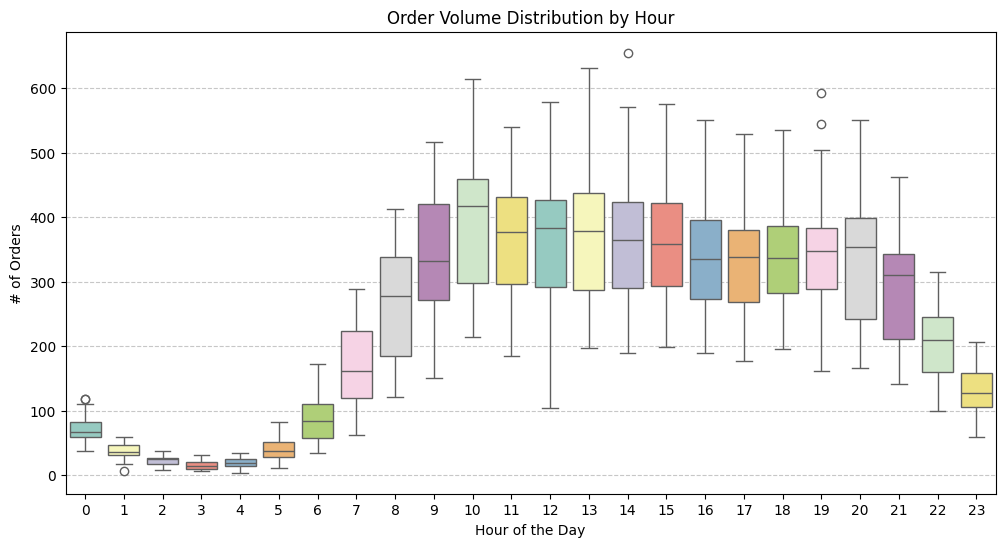

In [ ]:
# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='count', data=hourly_avg, palette="Set3")

# Add labels and title
plt.title("Order Volume Distribution by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("# of Orders")
plt.xticks(range(24))  # Ensure all hours are shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Numerical Features Analysis
Low Discriminatory Power for Features 'b', 'h', and 'k':
  - Based on visual analysis, these features do not appear to contribute significantly to distinguishing fraudulent from non-fraudulent transactions.
  - Despite this, they will be retained in the first iteration of the modeling process for further evaluation.

In [ ]:
# I'll already excluded equal columns here
numeric_cols = ["b", 'e', 'f',
                'h', 'k', 'l',
                'm', 'q', 'r',
                'amount']

outlier_cols = ['e', 'f',
                'r', 'amount']

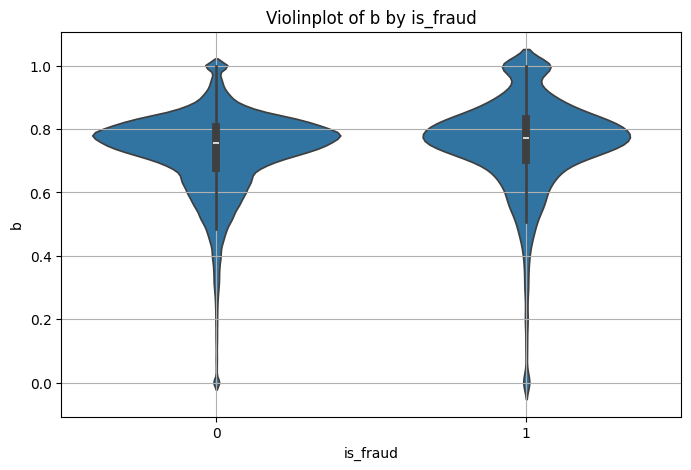

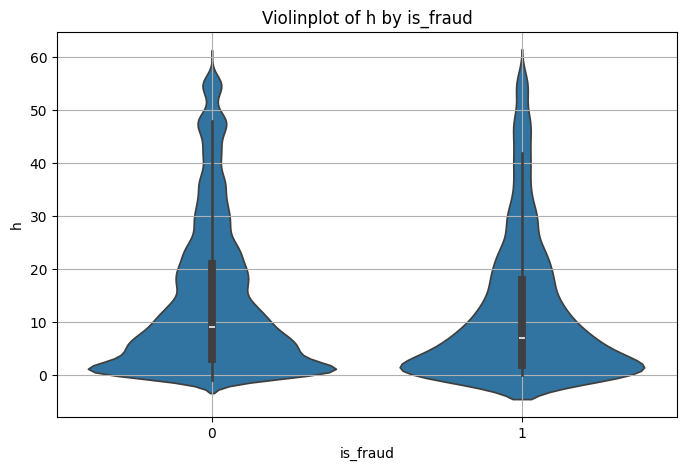

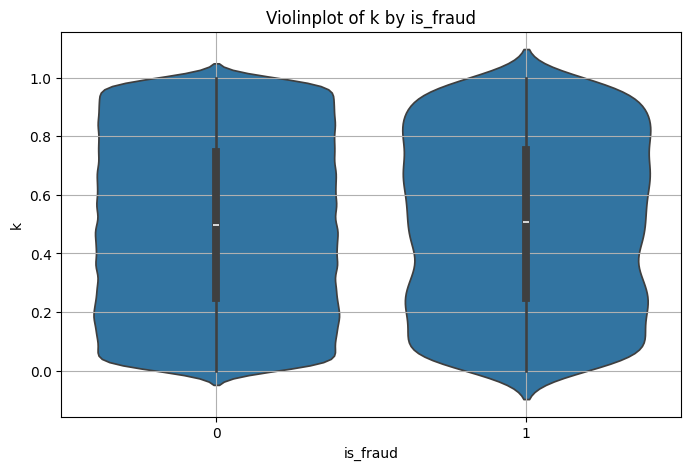

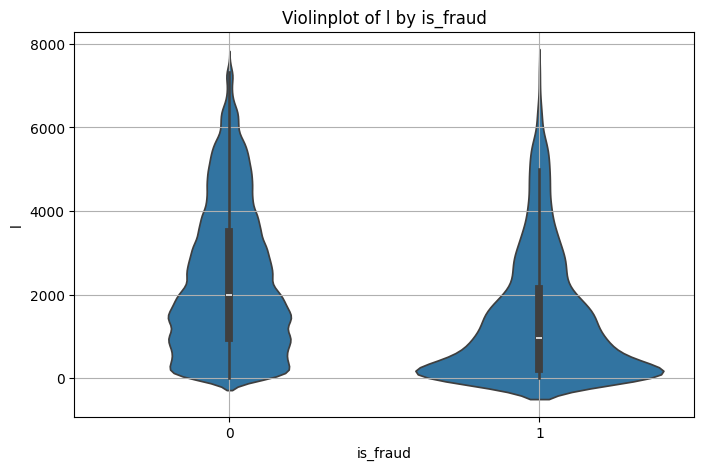

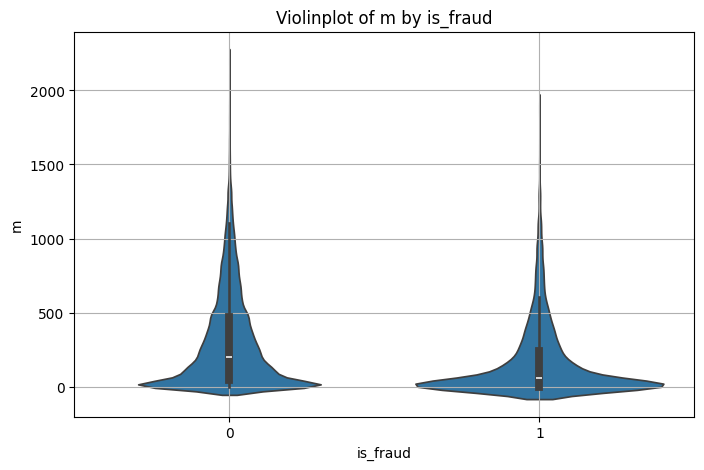

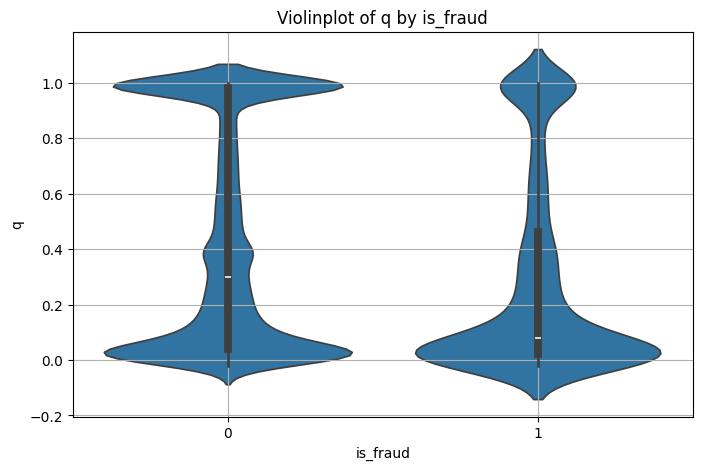

In [ ]:
for col in [col for col in numeric_cols if col not in outlier_cols]:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=analysis_data['is_fraud'], y=analysis_data[col])
    plt.title(f"Violinplot of {col} by is_fraud")
    plt.xlabel("is_fraud")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

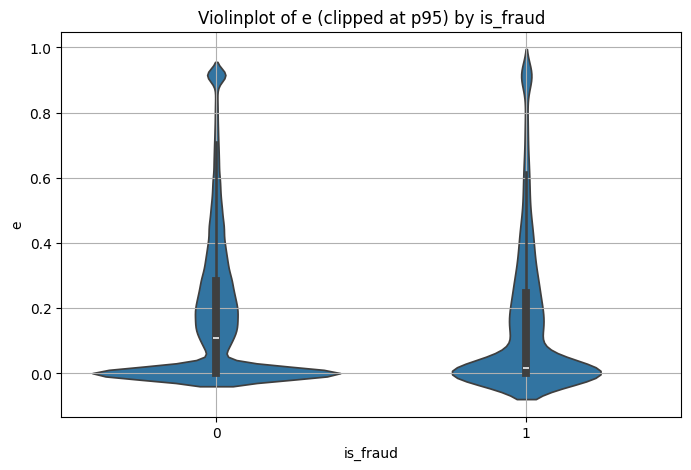

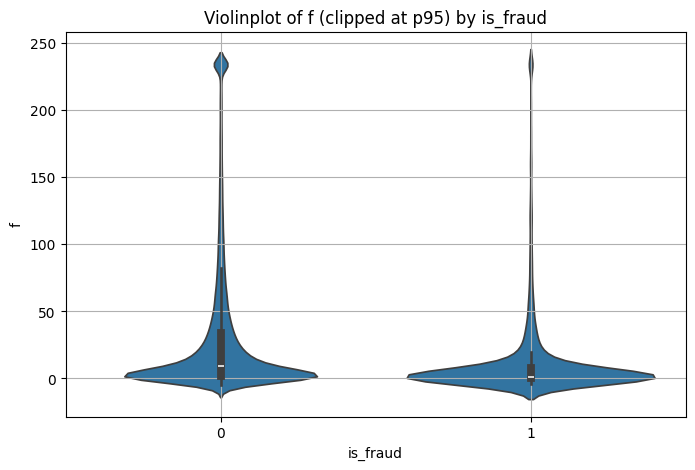

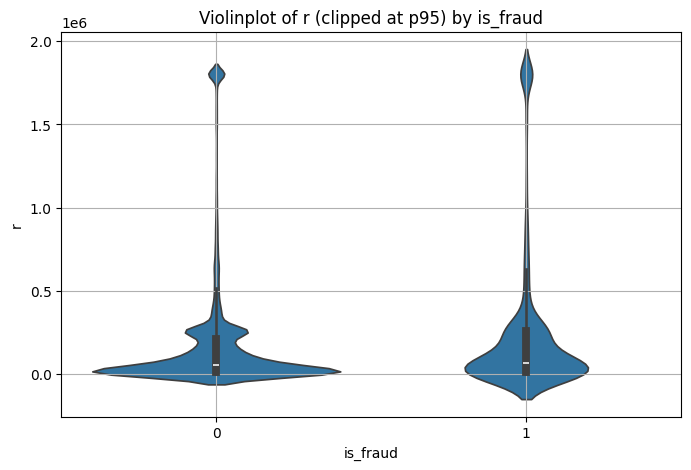

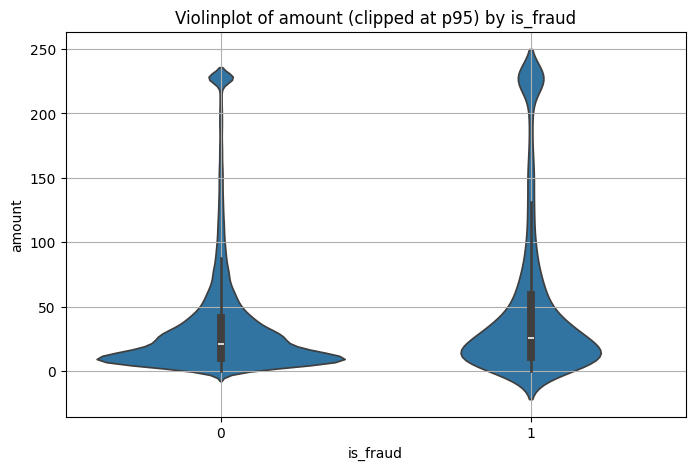

In [ ]:
# clip columns with outliers to increase visualization insights
for col in outlier_cols:
    plt.figure(figsize=(8, 5))
    clipped_y = analysis_data[col].clip(upper=analysis_data[col].quantile(0.97))
    sns.violinplot(x=analysis_data['is_fraud'], y=clipped_y)
    plt.title(f"Violinplot of {col} (clipped at p95) by is_fraud")
    plt.xlabel("is_fraud")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

## Categorical Feature Analysis
- All features present some discriminatory power (visually)
- Category 'cat_1' (Previously Feature 'a') = 5:
  - This category has no fraud cases despite representing 10% of the dataset.
  - In a real-world setting, this would require further investigation or additional data collection to determine whether fraud is truly absent or simply underreported.
  - For this analysis, it will be retained as it provides a super strong predictive signal.

In [ ]:
analysis_data['is_night_hours'] = np.where(
    analysis_data.ts.dt.hour.between(6, 22),
    "normal_period",
    "dawn_period"
)
cat_cols = [
    col for col in
    analysis_data.select_dtypes(include=['object', 'category']).columns
    if col not in ['bool_4']
]

<ipython-input-41-6176e89266ee>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




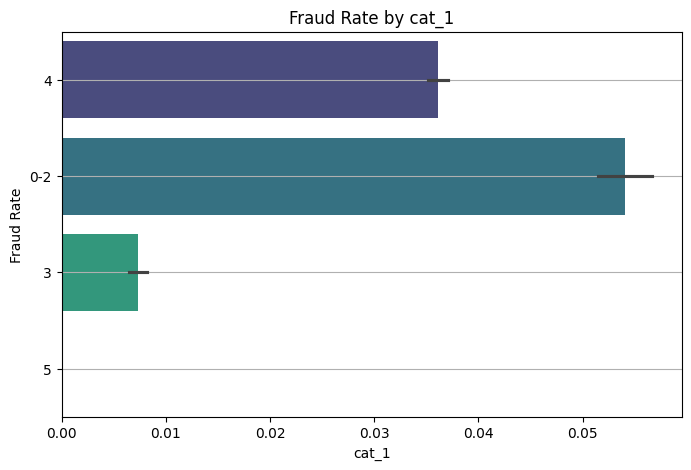

<ipython-input-41-6176e89266ee>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




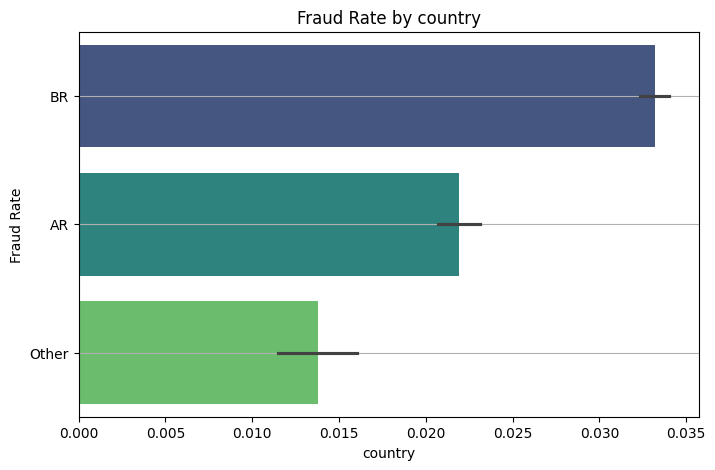

<ipython-input-41-6176e89266ee>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




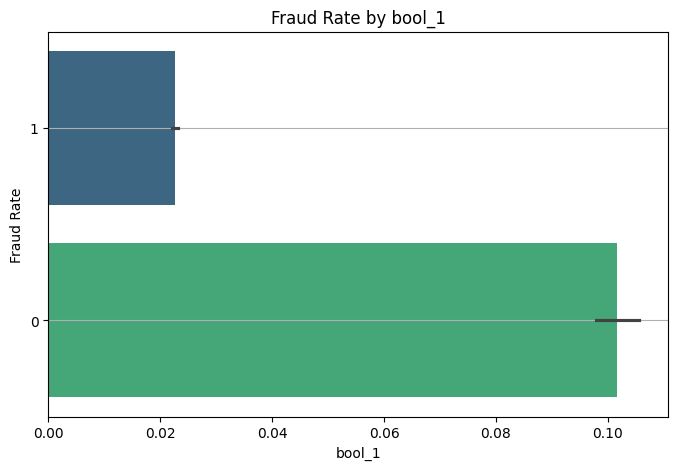

<ipython-input-41-6176e89266ee>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




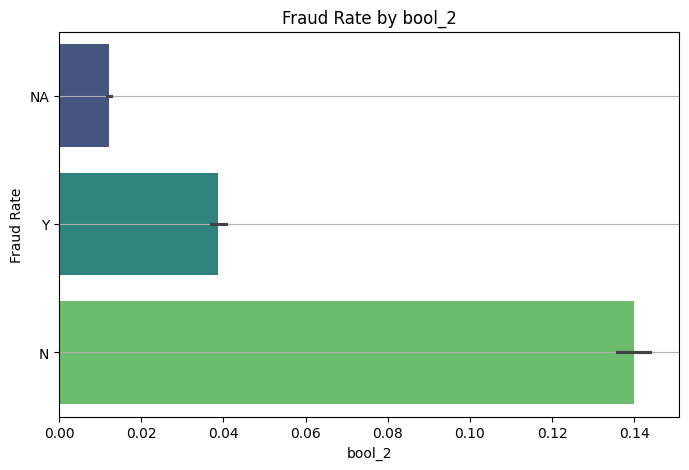

<ipython-input-41-6176e89266ee>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




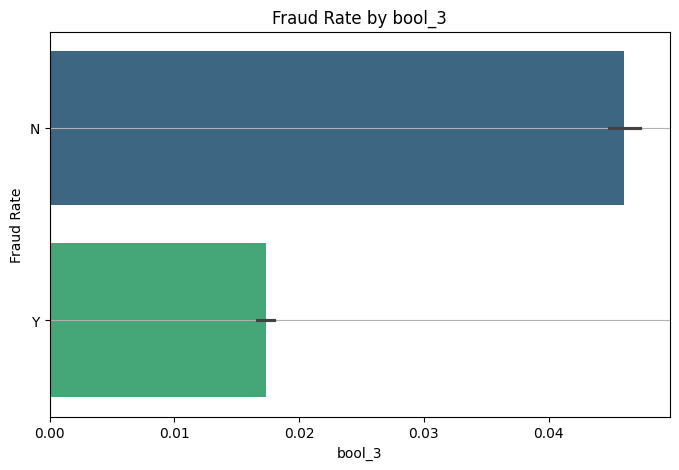

<ipython-input-41-6176e89266ee>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




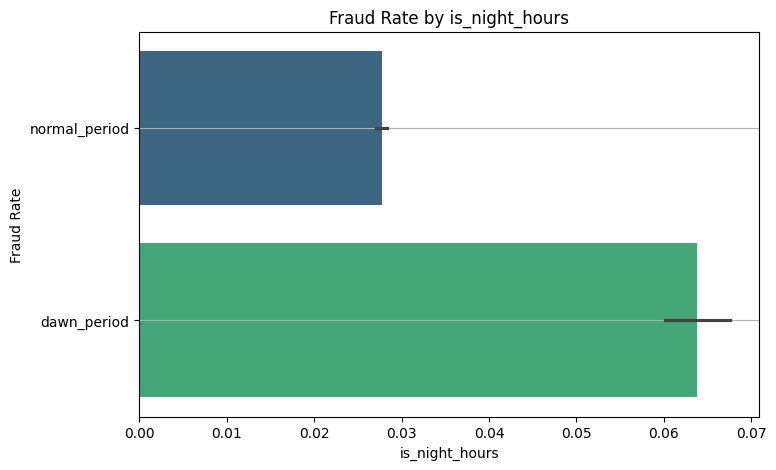

In [ ]:
# Create bar plots for fraud rate per category
for col in cat_cols:

    plt.figure(figsize=(8, 5))
    sns.barplot(x='is_fraud', y=col, data=analysis_data, palette='viridis')
    plt.title(f"Fraud Rate by {col}")
    plt.xlabel(col)
    plt.ylabel("Fraud Rate")
    #plt.ylim(0, 0.2)  # Fraud rate ranges from 0 to 1
    plt.grid(True, axis='y')
    plt.show()

## Highly correlated feature analysis

('bool_3', 'bool_4'): These features are identical, so 'bool_4' will be dropped.

In [ ]:
contingency_table = pd.crosstab(analysis_data['bool_3'], analysis_data['bool_4'])
contingency_table

bool_4,0,100
bool_3,,
N,109404,0
Y,0,139674


('c', 'r'): Feature 'r' is equivalent to np.floor(c), but with fewer missing values. Therefore, 'c' will be dropped.

<Axes: xlabel='c', ylabel='r'>

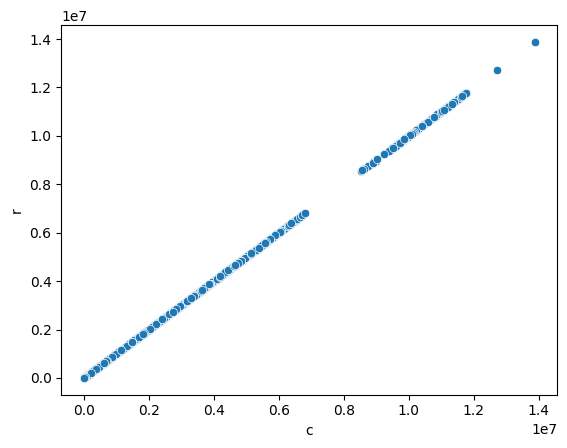

In [ ]:
sns.scatterplot(x='c', y='r', data=analysis_data)

In [ ]:
analysis_data[['c', 'r']][:5]

,c,r
0,94436.24,94436
1,9258.50,9258
2,242549.09,242549
3,18923.90,18923
4,5728.68,5728


('d', 'q'): 'd' follows a linear transformation of 'q' (d = B * q + N). Since 'q' provides the same information, 'd' will be removed.

<Axes: xlabel='q', ylabel='d'>

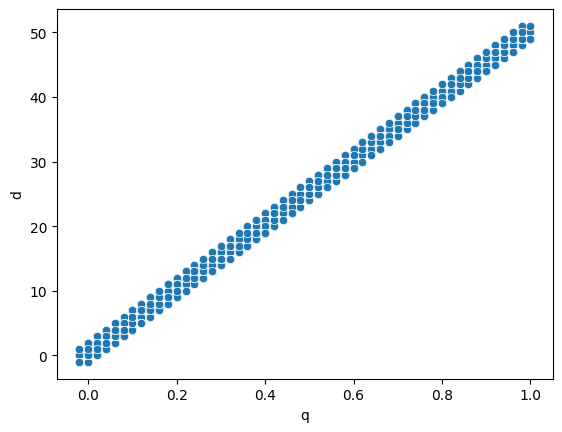

In [ ]:
sns.scatterplot(x='q', y='d', data=analysis_data)

In [ ]:
res = sm.OLS(exog=analysis_data['q'], endog=analysis_data['d']).fit()
res.summary()
# res.scale ## print the estimated variance of the error

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      d   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          3.419e+08
Date:                Sun, 09 Feb 2025   Prob (F-statistic):                        0.00
Time:                        23:54:27   Log-Likelihood:                     -2.9796e+05
No. Observations:              249078   AIC:                                  5.959e+05
Df Residuals:                  249077   BIC:                                  5.959e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
q             50.6093      0.003   1.85e+04      0.000      50.604      50.615
==============================================================================
Omnibus:                      835.038   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              641.868
Skew:                          -0.018   Prob(JB):                    4.17e-140
Kurtosis:                       2.754   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Aditional Filter Method

- The default Predictive Power Score (PPS) test (from Deepchecks) did not yield meaningful insights.
- To further assess univariate feature importance, Mutual Information (MI) was chosen due to its robustness in detecting non-linear associations and its suitability for large datasets.
- However, MI also failed to provide strong insights, likely due to the extreme class imbalance in the dataset.

In [ ]:
mutual_info_classif(
    analysis_data[numeric_cols].fillna(-10), analysis_data.is_fraud
)

array([0.00373214, 0.00366428, 0.00819273, 0.00257676, 0.00573144,
       0.0090868 , 0.00574349, 0.00806151, 0.00601445, 0.00339056])

In [ ]:
mutual_info_classif(
    analysis_data[cat_cols].astype("category"),
    analysis_data.is_fraud,
    discrete_features=True
)

array([0.00656906, 0.00062612, 0.00603091, 0.01720943, 0.00350412])

## Model DF Definition
- Create feature based on time and drop problematic columns
- Also, enforce dtype category for the modeling phase ahead

In [ ]:
model_data = (
    analysis_data
    .copy() # avoid changes to the original data
    .assign(
        is_night_hours=lambda x: np.where(
          x.ts.dt.hour.between(6, 22),
          "normal_period",
          "dawn_period"
        )
    )
    .drop(columns=['q', 'r', 'bool_4'])
    .sort_values('ts')
)

# categorical feature list
cat_features = (
    model_data
    .select_dtypes(include=['object', 'category'])
    .columns
    .to_list()
)

# encoding of categorical features to work the same way on all models
for c in cat_features:
  model_data[c] = model_data[c].astype('category')

# Modeling

- **Metrics**: The fraud detection model will be evaluated using PR-AUC as the primary metric, with LogLoss, Brier Score, and ROC-AUC as supporting metrics.

  - PR-AUC is chosen for its ability to assess fraud detection performance without a predefined threshold, aligning with the need for cost-based decision-making.
  - Brier Score ensures probability calibration for financial optimization.
  - LogLoss penalizes incorrect confident predictions, and ROC-AUC measures overall discrimination.
  - Since profit maximization is the goal, the final threshold will be set based on a cost-benefit analysis rather than Precision and Recall alone.
- **Data split strategy**:
  - The test set comprises the most recent 20% of data to simulate a training vs. production environment.
  - While no strong time dependency was detected, this split avoids potential data leakage since user information is unavailable.
  - Validation tests confirmed the split's consistency and suitability.
- **CV Strategy**:
  - A stratified 5-fold CV ensures fraud distribution across folds, as time-based CV is unnecessary given the dataset’s characteristics.
  - The large data volume allows for better generalization with multiple CV folds.
- **Candidate Models**:
  - XGBoost, LightGBM, and CatBoost are selected due to their strong handling of missing values, skewed distributions, and feature interactions.
  - Extensive [research](https://arxiv.org/pdf/2407.00956) supports boosted trees as top performers for tabular data.
  - Each model has unique strengths, warranting thorough testing.
- Feature Selection: as we don't have domain knowledge to assess if a feature is suited in terms of causal relationships or Data Genaration Process, I'll rely on variability vs. importance checks, omitting wrapper methods due to computational constraints.(Wrapper methods were out of scope due to high effort needed)
- Hyperparameter tuning: Bayesian Optimization (TPE via Optuna) was used for efficiency. Due to computational limits, tuning was performed on a subset of key parameters.





## Data Split
- The test set comprises the most recent 20% of data to simulate a training vs. production environment.
- While no strong time dependency was detected, this split avoids potential data leakage since user information is unavailable.
- Validation tests confirmed the split's consistency and suitability.

In [ ]:
## train test split objects
train_size = TRAIN_SIZE
# there is exactly 2 similar payments with '2020-04-14 19:27:44' ts, so I skipped once to not raise the alarm below
train_sample = int(train_size * len(model_data)) + 1

train_set = model_data.iloc[:train_sample]
test_set = model_data.iloc[train_sample:]

X_train, y_train = train_set.drop(columns=[TARGET, TS_COLUMN]), train_set[TARGET]
X_test, y_test = test_set.drop(columns=[TARGET, TS_COLUMN]), test_set[TARGET]

In [ ]:
# deepchecks objects
train_ds = Dataset(train_set, label=TARGET,
                   cat_features=cat_features, datetime_name=TS_COLUMN)
test_ds = Dataset(test_set, label=TARGET,
                  cat_features=cat_features, datetime_name=TS_COLUMN)

In [ ]:
validation_suite = train_test_validation()
suite_result = validation_suite.run(train_ds, test_ds)
suite_result.show()

/usr/local/lib/python3.11/dist-packages/deepchecks/tabular/checks/train_test_validation/train_test_samples_mix.py:129: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/deepchecks/tabular/checks/train_test_validation/train_test_samples_mix.py:129: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/deepchecks/tabular/checks/train_test_validation/train_test_samples_mix.py:85: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Train Test Validation Suite

## New Model Definition
- **Metrics**: The fraud detection model will be evaluated using PR-AUC as the primary metric, with LogLoss, Brier Score, and ROC-AUC as supporting metrics.
  - PR-AUC is chosen for its ability to assess fraud detection performance without a predefined threshold, aligning with the need for cost-based decision-making.
  - Brier Score ensures probability calibration for financial optimization.
  - LogLoss penalizes incorrect confident predictions, and ROC-AUC measures overall discrimination.
  - Since profit maximization is the goal, the final threshold will be set based on a cost-benefit analysis rather than Precision and Recall alone.
- **CV Strategy**:
  - A stratified 5-fold CV ensures fraud distribution across folds, as time-based CV is unnecessary given the dataset’s characteristics.
  - The large data volume allows for better generalization with multiple CV folds.
- **Candidate Models**:
  - XGBoost, LightGBM, and CatBoost are selected due to their strong handling of missing values, skewed distributions, and feature interactions.
  - Extensive [research](https://arxiv.org/pdf/2407.00956) supports boosted trees as top performers for tabular data.
  - Each model has unique strengths, warranting thorough testing.

In [ ]:
# Custom scoring functions
scoring_metrics = {
    'pr_auc': make_scorer(average_precision_score, needs_proba=True),
    'log_loss': make_scorer(log_loss, needs_proba=True),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'brier_loss': make_scorer(brier_score_loss, needs_proba=True)
}
# Conteder models
models = {
    'CatBoost': CatBoostClassifier(
        cat_features=cat_features, verbose=200, thread_count=-1,
        # it's really painfull to train it without GPU usage
        task_type='GPU', random_state=RANDOM_SEED
    ),
    'LightGBM': LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    'XGBoost': XGBClassifier(
        eval_metric='logloss',
        enable_categorical=True,
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),
}

# Stratified K-Fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning:

The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.



In [ ]:
models_perf = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    models_perf[model_name] = cross_validate(model, X_train, y_train,
                                             cv=skf, scoring=scoring_metrics)

Evaluating CatBoost...
Learning rate set to 0.025506
0:	learn: 0.6507643	total: 70.4ms	remaining: 1m 10s
200:	learn: 0.0981091	total: 5.73s	remaining: 22.8s
400:	learn: 0.0947229	total: 9.57s	remaining: 14.3s
600:	learn: 0.0926978	total: 16.2s	remaining: 10.7s
800:	learn: 0.0910894	total: 20s	remaining: 4.97s
999:	learn: 0.0895893	total: 23.8s	remaining: 0us
Learning rate set to 0.025506
0:	learn: 0.6507939	total: 10.7ms	remaining: 10.7s
200:	learn: 0.0987608	total: 5.9s	remaining: 23.5s
400:	learn: 0.0954296	total: 9.74s	remaining: 14.5s
600:	learn: 0.0934115	total: 13.6s	remaining: 9.01s
800:	learn: 0.0917341	total: 20.1s	remaining: 4.99s
999:	learn: 0.0902479	total: 23.9s	remaining: 0us
Learning rate set to 0.025506
0:	learn: 0.6507442	total: 10ms	remaining: 9.99s
200:	learn: 0.0987366	total: 4.02s	remaining: 16s
400:	learn: 0.0954876	total: 10.2s	remaining: 15.3s
600:	learn: 0.0935323	total: 14.1s	remaining: 9.35s
800:	learn: 0.0919063	total: 19.5s	remaining: 4.84s
999:	learn: 0.09

All models exhibited similar performance across all metrics. Therefore, I will assume they perform equivalently on average, despite not conducting a formal statistical test.
Given the nature of the problem—fraud detection in an online service—technical constraints can be considered secondary. As a result, I am selecting **XGBoost** due to its consistently superior performance in both training efficiency and inference speed.

In [ ]:
avg_perf = []
for model, metrics in models_perf.items():
    avg_perf.append({
            "Model": model,
            "Average Fit Time": np.mean(metrics["fit_time"]),
            "Average Score Time": np.mean(metrics["score_time"]),
            "Average PR AUC": np.mean(metrics["test_pr_auc"]),
            "Average Log Loss": np.mean(metrics["test_log_loss"]),
            "Average ROC AUC": np.mean(metrics["test_roc_auc"]),
            "Average Brier Score Loss": np.mean(metrics["test_brier_loss"])
    })

pd.DataFrame(avg_perf)

,Model,Average Fit Time,Average Score Time,Average PR AUC,Average Log Loss,Average ROC AUC,Average Brier Score Loss
0,CatBoost,33.922444,0.222285,0.354961,0.097053,0.886054,0.024210
1,LightGBM,3.038336,0.250104,0.349572,0.096832,0.888115,0.024304
2,XGBoost,3.000314,0.173095,0.350348,0.097737,0.884544,0.024342


- Hyperparameter tuning: Bayesian Optimization (TPE via Optuna) was used for efficiency. Due to computational limits, tuning was performed on a subset of key parameters. Unfortunately, the search didn't produce meaningfull results
- Feature Selection: as we don't have domain knowledge to assess if a feature is suited in terms of causal relationships or Data Genaration Process, I'll rely on variability vs. importance checks, omitting wrapper methods due to computational constraints.(Wrapper methods were out of scope due to high effort needed)

In [ ]:
def objective(trial):
    "Adapted from Optuna documentation: https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py"
    # fixed parameters -- TODO: tried to insert them dinamically, but it produces an error. See if there is a better way
    fixed_params = {
        'eval_metric': 'logloss',
        'enable_categorical': True,
        'random_state': RANDOM_SEED,
        'n_jobs': -1
    }

    # Define the hyperparameter search space
    trial_params = {
        ## prioritised parameters (use all of them would demand Ray implementation)
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # learning rate
        "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        # defines how selective algorithm is (minimum loss reduction required to make a further partition on a leaf node)
        "gamma":  trial.suggest_float("gamma", 1e-8, 1.0, log=True),
    }

    # Combine fixed and trial-specific parameters
    params = {**fixed_params, **trial_params}

    # Initialize a list to store the PRAUC for each fold
    pr_auc_scores = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_kfold, X_val_kfold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_kfold, y_val_kfold = y_train.iloc[train_index], y_train.iloc[val_index]

        model = XGBClassifier(**params)

        model.fit(X_train_kfold,y_train_kfold,)

        model.fit(X_train_kfold, y_train_kfold)
        y_pred_proba = model.predict_proba(X_val_kfold)[:, 1]

        pr_auc = average_precision_score(y_val_kfold, y_pred_proba)
        pr_auc_scores.append(pr_auc)

    return np.mean(pr_auc_scores)

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Output the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2025-02-08 17:19:09,011] A new study created in memory with name: no-name-8555c6bc-03d7-4b29-a8a1-ee3266a76aea


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-02-08 17:20:31,731] Trial 0 finished with value: 0.2507079201986843 and parameters: {'lambda': 0.05092651345778503, 'alpha': 0.0006212376899589892, 'eta': 1.045195338926967e-05, 'max_depth': 7, 'gamma': 0.04791255905850875}. Best is trial 0 with value: 0.2507079201986843.
[I 2025-02-08 17:21:54,622] Trial 1 finished with value: 0.25402637860838473 and parameters: {'lambda': 4.1351086557354984e-05, 'alpha': 1.0721340531014293e-06, 'eta': 4.079256754350021e-05, 'max_depth': 7, 'gamma': 2.1689774639195767e-05}. Best is trial 1 with value: 0.25402637860838473.
[I 2025-02-08 17:22:24,327] Trial 2 finished with value: 0.3240458092161471 and parameters: {'lambda': 1.4525615308617057e-08, 'alpha': 0.3119824223780318, 'eta': 0.1046055769857921, 'max_depth': 3, 'gamma': 0.030548645683790038}. Best is trial 2 with value: 0.3240458092161471.
[I 2025-02-08 17:23:03,855] Trial 3 finished with value: 0.16353378271358393 and parameters: {'lambda': 0.02047541779242845, 'alpha': 0.43015249929135

In [ ]:
display(vis.plot_param_importances(study))
display(vis.plot_optimization_history(study))

## Final model analysis

- Model passed most important tests (unfortunately, I couldn't manage to assess performance variability test on the main metric)
- Feature importance analysis was executed throught SHAP values due to their agnosticity and capability of providing both local and global insights regarding feature importance
- cat_1 was, as expected, the most important feature - again, reminder of investigating it more prior to deploying the model into production

In [ ]:
# Initialize and train the model
best_model = models["XGBoost"]
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# DC current version isn't compatible with numpy v2. Issue already open: https://github.com/deepchecks/deepchecks/issues/2790
evaluation_suite = model_evaluation(scorers=['average_precision'])
suite_result = evaluation_suite.run(train_ds, test_ds, best_model)

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:



In [ ]:
#spliting the show to avoid the numpy warnings
suite_result.show()

<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Model Evaluation Suite

In [ ]:
# clearly, the class some issues. Among these, it has a different API to use alternative scorers
check = WeakSegmentsPerformance(
    alternative_scorer={'average_precision': 'average_precision'},
    categorical_aggregation_threshold=0,  # Disable category aggregation
    max_categories_weak_segment=None,      # Allow unlimited categories per segment
    segment_minimum_size_ratio=0.01  # Allow segments as small as 1% of the data
)
result = check.run(test_ds, best_model)

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast

/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:



In [ ]:
result.show()

<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Weak Segments Performance

In [ ]:
explainer = shap.TreeExplainer(best_model)

#%time shap_values = explainer(X_train)
shap_values = explainer(X_train)

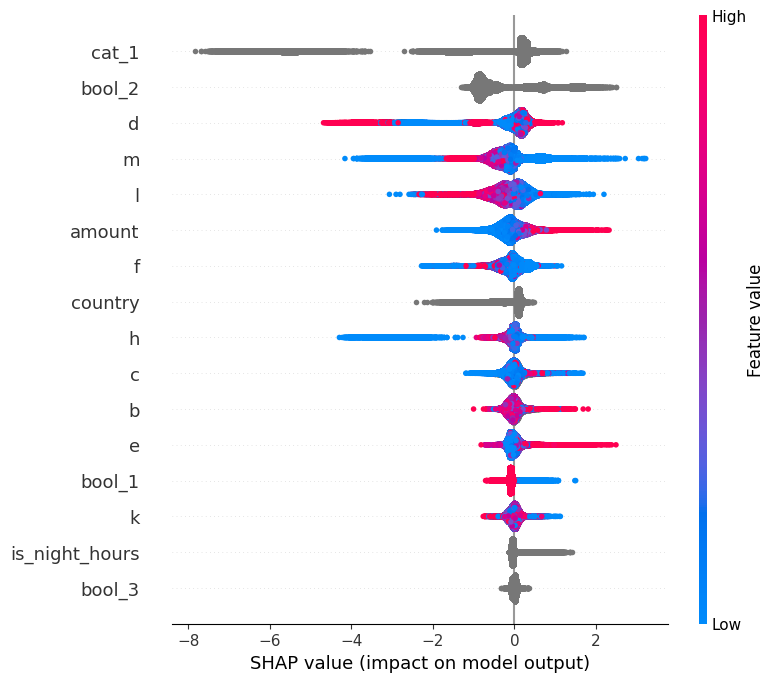

In [ ]:
shap.plots.beeswarm(shap_values, max_display=17)

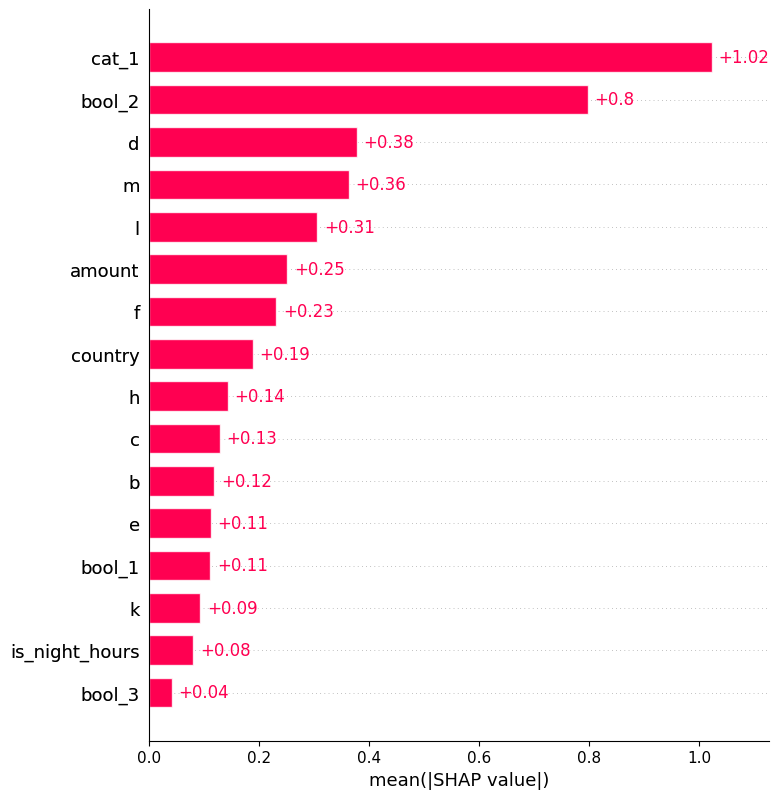

In [ ]:
shap.plots.bar(shap_values, max_display=17)

## Old vs New Comparison
- The new model outperforms consistently the old model in all metrics, showing a great potential of increasing the financial results with it

In [ ]:
y_pred_proba_model_v0 = (
    y_test.to_frame()
    .join(staging_data[['v0_model_score']], how='left')
    .v0_model_score
    .apply(lambda x: x / 100.0)
)
y_pred_proba_model_v1 = best_model.predict_proba(X_test)[:, 1]

results = {
    'model_v0': {metric_name: scorer._score_func(y_test, y_pred_proba_model_v0)
                for metric_name, scorer in scoring_metrics.items()},
    'model_v1': {metric_name: scorer._score_func(y_test, y_pred_proba_model_v1)
                for metric_name, scorer in scoring_metrics.items()}
}

pd.DataFrame(results).T

,pr_auc,log_loss,roc_auc,brier_loss
model_v0,0.165981,0.819610,0.730272,0.257849
model_v1,0.280581,0.088101,0.880321,0.021703


# Business Assessment
- The new model outperforms the previous one, but its true value lies in profit maximization through better decisions.
- TunedThresholdClassifierCV, along with a scorer function that materializes how the model produce profit, determines the optimal threshold, ensuring it generalizes well across CV folds before final test evaluation.
- A profit curve confirms successful generalization, achieving near-optimal performance on the test set.
- The optimization heavily penalizes precision, blocking nearly 10× more legitimate transactions than actual fraud cases, which may impact customer engagement.
- A dynamic threshold based on transaction value could reduce unintended effects without significantly sacrificing revenue.

## Profit Optimization

In [ ]:
tuned_model = TunedThresholdClassifierCV(
    estimator=best_model,
    scoring=business_scorer,
    n_jobs=-1,
    cv=skf
)

tuned_model.fit(X_train, y_train, amount=X_train.amount)

TunedThresholdClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                           estimator=XGBClassifier(base_score=None,
                                                   booster=None, callbacks=None,
                                                   colsample_bylevel=None,
                                                   colsample_bynode=None,
                                                   colsample_bytree=None,
                                                   device=None,
                                                   early_stopping_rounds=None,
                                                   enable_categorical=True,
                                                   eval_metric='logloss',
                                                   feature_types=None,
                                                   gamma=None, grow_policy=N...
                                                   learning_rate=None,
                                                   max_bin=None,
                                                   max_cat_threshold=None,
                                                   max_cat_to_onehot=None,
                                                   max_delta_step=None,
                                                   max_depth=None,
                                                   max_leaves=None,
                                                   min_child_weight=None,
                                                   missing=nan,
                                                   monotone_constraints=None,
                                                   multi_strategy=None,
                                                   n_estimators=None, n_jobs=-1,
                                                   num_parallel_tree=None,
                                                   random_state=42, ...),
                           n_jobs=-1,
                           scoring=make_scorer(business_metric, response_method='predict'))

In [ ]:
best_threshold = tuned_model.best_threshold_
exp_profit = business_scorer(tuned_model, X_test, y_test,
                amount=X_test.amount)

print(f"Tuned decision threshold: {best_threshold:.2f}")
print(
    f"Benefit of logistic regression with a tuned threshold: {exp_profit:,.2f}$"
)

Tuned decision threshold: 0.03
Benefit of logistic regression with a tuned threshold: 60,394.20$


- The profit curve confirms successful generalization, achieving near-optimal performance on the test set.
- It also shows that, even if the old model was perfectly tunned, the new model can increase in 20% its performance

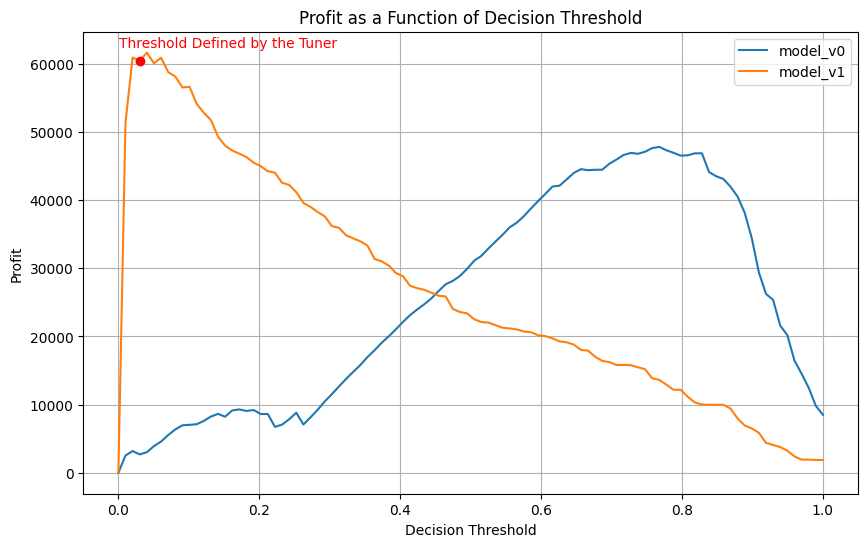

In [ ]:
# lists to store thresholds and corresponding costs
thresholds = np.linspace(0, 1, 100)

costs = {'model_v0': [], 'model_v1': [],
         'thresh_v0': [], 'thresh_v1': []}
# Calculate the cost for each threshold
for threshold in thresholds:
    y_pred_model_v0 = (y_pred_proba_model_v0 >= threshold).astype(int)
    costs['thresh_v0'].append(threshold)
    cost_model_v0 = business_metric(y_test, y_pred_model_v0, X_test['amount'].values)
    costs['model_v0'].append(cost_model_v0)
    costs['thresh_v1'].append(threshold)
    y_pred_model_v1 = (y_pred_proba_model_v1 >= threshold).astype(int)
    cost_model_v1 = business_metric(y_test, y_pred_model_v1, X_test['amount'].values)
    costs['model_v1'].append(cost_model_v1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs['model_v0'], label='model_v0')
plt.plot(thresholds, costs['model_v1'], label='model_v1')
# Add a dashed horizontal line at y=1000
plt.scatter(best_threshold, exp_profit, color='red', zorder=5)
plt.annotate(f'Threshold Defined by the Tuner',
             (best_threshold, exp_profit),
             textcoords="offset points", xytext=(-15,10), ha='left', color='red')

plt.xlabel('Decision Threshold')
plt.ylabel('Profit')
plt.title('Profit as a Function of Decision Threshold')
plt.legend()
plt.grid()
plt.show()

## Operational Considerations
- The optimization heavily penalizes precision, blocking nearly 10× more legitimate transactions than actual fraud cases, which may impact customer engagement.
- A dynamic threshold based on transaction value could reduce unintended effects without significantly sacrificing revenue.

In [ ]:
precision = precision_score(test_set.is_fraud, tuned_model.predict(X_test))
recall = recall_score(test_set.is_fraud, tuned_model.predict(X_test))
pct_denied_orders = np.mean(tuned_model.predict(X_test))
print(f"Tuned Model Precision: {precision:.2f}")
print(f"Tuned Model Recall: {recall:.2f}")
print(f"Payments declined by the Tuned Model: {pct_denied_orders:.2%}")

Tuned Model Precision: 0.10
Tuned Model Recall: 0.77
Payments declined by the Tuned Model: 19.55%


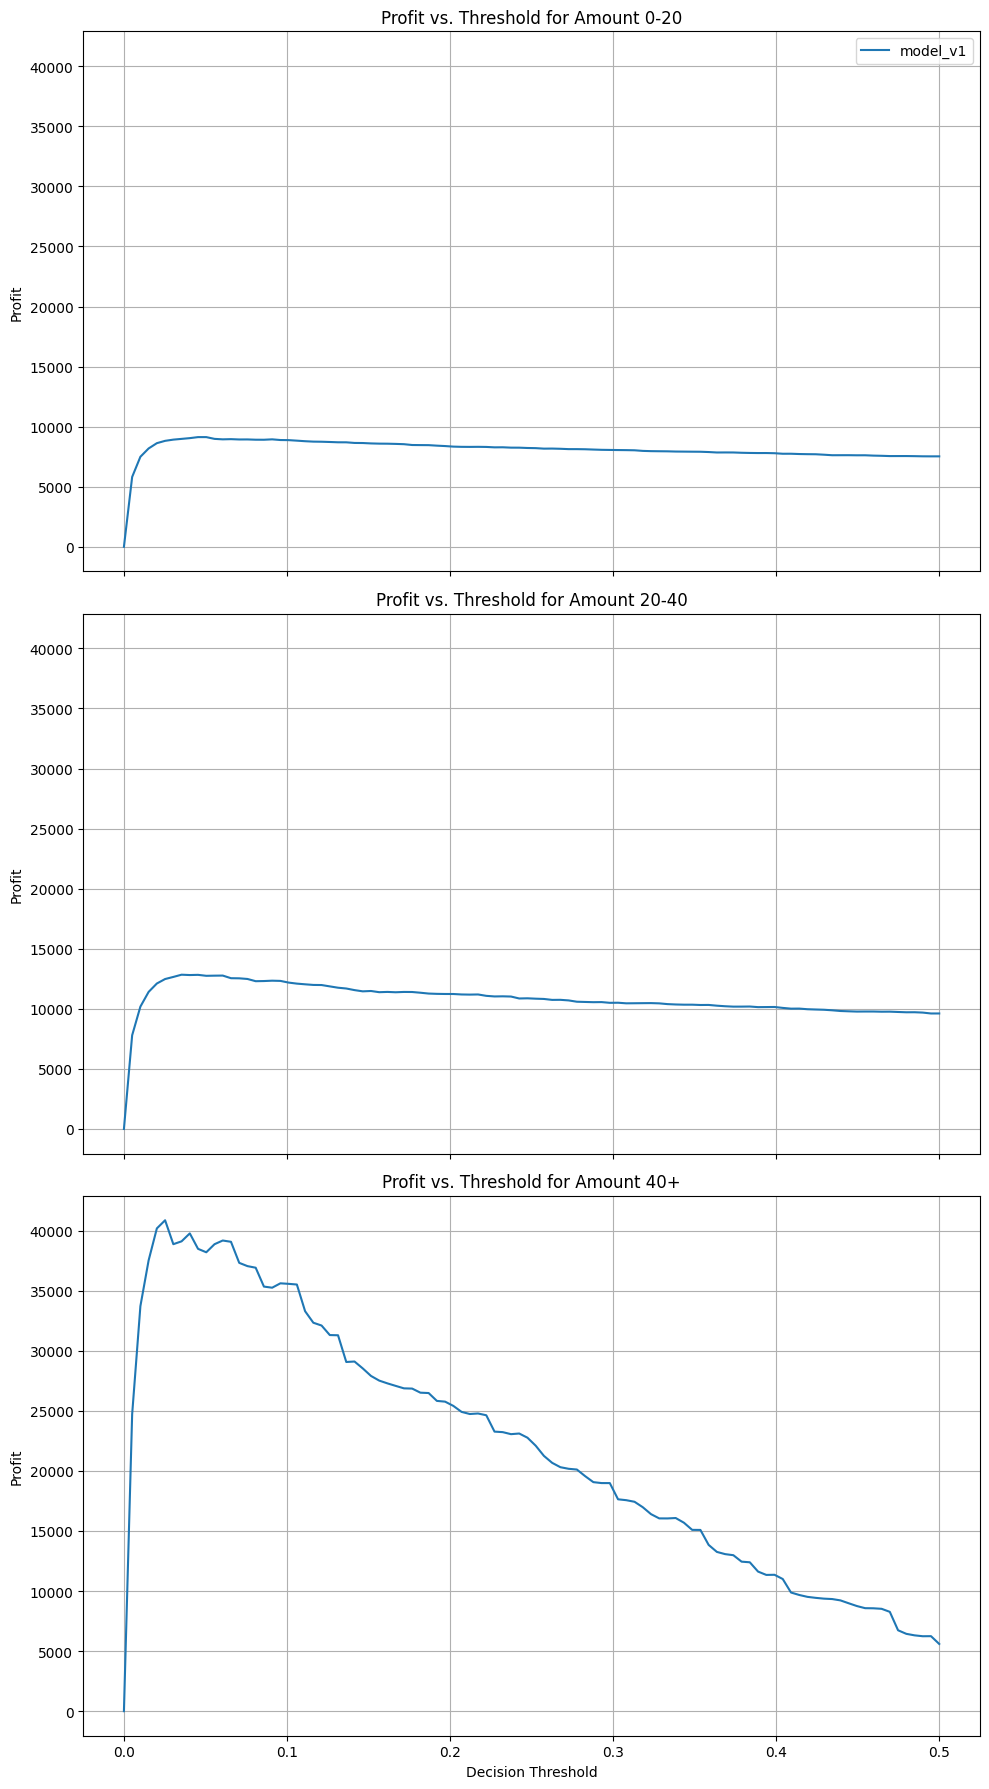

In [ ]:
# p25, p50, p75: 10, 20, 40
amount_intervals = [(0, 20), (20, 40), (40, np.inf)]
interval_labels  = ['0-20', '20-40','40+']

# Define the decision thresholds to evaluate
thresholds = np.linspace(0, 0.5, 100)

# Create subplots: 3 rows, 1 column
fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True, sharey=True)

for ax, (low, high), label in zip(axs, amount_intervals, interval_labels):
    # Filter data for the current amount interval
    if np.isfinite(high):
        mask = (X_test['amount'] >= low) & (X_test['amount'] < high)
    else:
        mask = (X_test['amount'] >= low)

    y_test_subset                = y_test[mask]
    amounts_subset               = X_test.loc[mask, 'amount'].values
    y_pred_proba_model_v1_subset = y_pred_proba_model_v1[mask]

    # List to store profits for model_v1
    profits_model_v1 = []

    # Calculate expected profit for each threshold
    for threshold in thresholds:
        # Generate predictions for model_v1 based on the current threshold
        y_pred_v1 = (y_pred_proba_model_v1_subset >= threshold).astype(int)
        profit    = business_metric(y_test_subset, y_pred_v1, amounts_subset)
        profits_model_v1.append(profit)

    # Plot the profit curve for model_v1 in the current amount interval
    ax.plot(thresholds, profits_model_v1, label='model_v1')
    ax.set_title(f'Profit vs. Threshold for Amount {label}')
    ax.set_ylabel('Profit')
    ax.grid()

# Set the x-axis label for the bottom subplot and add a legend to the top subplot
axs[-1].set_xlabel('Decision Threshold')
axs[0].legend()

plt.tight_layout()
plt.show()

# Next Steps

The new model successfully enhances the current production solution. However, several areas could be improved in future iterations:

- Incorporate User and Payment Data: Fraud data exhibits a graph-like structure; integrating potential edges information from user and payment data could significantly enhance the model's discrimination capabilities through [Graph Neural Networks](https://developer.nvidia.com/blog/supercharging-fraud-detection-in-financial-services-with-graph-neural-networks/).
- Introduce Randomness in Fraud Analysis: Fraud models can create [negative feedback loops](https://www.youtube.com/watch?v=v8sQiKqQ_pw), as over time, only riskier orders are scrutinized. Implementing randomness, either through small random allocations or a softmax layer, can help break these loops and potentially enable causal inference-based approaches.
- Apply Conformal Inference: All models have inherent uncertainty in their predictions. Adopting a framework like [Venn-Abers](https://github.com/ip200/venn-abers/blob/main/examples/simple_classification.ipynb) can enhance decision-making capabilities. Instead of relying solely on point predictions, decisions can be based on the lower bound of prediction intervals for increased conservativeness.
- Bayesian Optimisation for Feature Selection: besides incorporating real business knowledge to better manage which features to be tested, there are new approaches that make use of Bayesian Optimisation tecniques from [Optuna for Feature Selection](https://medium.com/towards-data-science/feature-selection-with-optuna-0ddf3e0f7d8c) purposes, then bringing all of its strengs into this similar field

# Model Deployment

In [ ]:
import pickle

# Assume `model` is your trained model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
# remeber to uninstall unnecessary dependencies
!{sys.executable} -m pip freeze > requirements.txt

In [ ]:
!zip model_package.zip model.pkl requirements.txt

["/usr/bin/python3: can't open file '/content/zip': [Errno 2] No such file or directory"]

# Appendix

Including the validation set improved marginally the performance of the model, but not enought to justify it's implementaiton

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
# from catboost import CatBoostClassifier
# import numpy as np
#
# # Lists to store metrics for each fold
# logloss_scores = []
# rocauc_scores = []
# brier_scores = []
#
# # Initialize Stratified K-Fold
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#
# for train_index, val_index in skf.split(X_train, y_train):
#     print("new_iter")
#     X_train_kfold, X_val_kfold = X_train.iloc[train_index], X_train.iloc[val_index]
#     y_train_kfold, y_val_kfold = y_train.iloc[train_index], y_train.iloc[val_index]
#
#     model = CatBoostClassifier(
#         cat_features=cat_features, verbose=10, thread_count=-1,
#         task_type='GPU'
#     )
#
#     # Fit the model with eval_set
#     model.fit(
#         X_train_kfold, y_train_kfold,
#         eval_set=(X_val_kfold, y_val_kfold),
#         use_best_model=True
#     )
#
#     # Predict probabilities
#     y_pred_proba = model.predict_proba(X_val_kfold)[:, 1]
#
#     # Calculate metrics
#     logloss_scores.append(log_loss(y_val_kfold, y_pred_proba))
#     rocauc_scores.append(roc_auc_score(y_val_kfold, y_pred_proba))
#     brier_scores.append(brier_score_loss(y_val_kfold, y_pred_proba))
#
# # Display average metrics
# print(f"Average Log Loss: {np.mean(logloss_scores):.4f}")
# print(f"Average ROC AUC: {np.mean(rocauc_scores):.4f}")
# print(f"Average Brier Score Loss: {np.mean(brier_scores):.4f}")
# Average Log Loss: 0.0967
# Average ROC AUC: 0.8870
# Average Brier Score Loss: 0.0241